# Using linear optimisation to calculate which stores to divest in a hypothetical merger

Consider if Costa and Starbucks (two coffee chains with a considerable presence in London) decided to merge, creating CostaBucks. A merger of this size would induce scrutiny from the relevant authorities - e.g. the Competitions and Markets Authority (CMA) in the UK. When analysing a merger, the CMA look at the potential effects that the merger would have on customers - e.g. if the merger parties have the ability to raise prices.

A typical first step is to first define the market in which the merged parties operate in. For a retail merger, this is often done at the local level - so for each store, their local market will be defined as the area within a certain distance of the store. Within this area, the authorities will look at the level of competition, and the reduction in competition that the merger would cause. 

One measure of the reduction in competition is the fascia count reduction. A fascia is defined as a unique store brand - so a fascia count is the number of unique store brands within a market. If there were six stores in a market with brands Costa, Costa, Starbucks, Pret, Pret, Caffe Nero, then this market has four fascia. Following a merger between two parties, the number of fascia in a market for which both parties were previously present must necessarily reduce by one. In the example above, the resulting stores in the market would be CostaBucks, CostaBucks, CostaBucks, Pret, Pret, Caffe Nero - thus a four to three merger in the number of fascia.

The decision on the outcome of a merger is usually not as a black and white as simply "allow" or "block". Instead, the CMA will often allow the merger subject to the condition that certain stores are divested - that is, sold to a third party. The stores needed to be sold are usually those that are in particularly problematic areas - i.e. those where there is the highest chance of a substantial lessening of competition (SLC). Using the fascia count reduction measure, this may be all those areas where the fascia reduction is a 4 to 3, 3 to 2 or 2 to 1. Using the same example, if the merging parties sold the original Starbucks store to Taylor St Baristas, then the resulting market would be CostaBucks, CostaBucks, Taylor St Baristas, Pret, Pret, Caffe Nero - four fascia, and thus no reduction in competition by per the fascia count reduction measure.

In practice, it is of course hard to know who exactly will buy the divestment stores, or whether they will just be shut down/sold to a different industry entirely. The first step is therefore just to identify the stores that would hypothetically solve any SLC areas, as an "offering" to the authorities - i.e. in each SLC area, offer up either all the Costa or all the Starbucks stores. 

The merging parties will naturally want to sell as few stores as possible to solve all of the necessary SLC areas. Whilst the solution to the above example is simple, the solution can get far more complex when multiple markets overlap with each other, as selling one store will have knock-on effects in the overlapping markets. This problem is perfect for linear optimisation - minimise the number of stores sold subject to the constraint that the SLC is solved in each local market.


In [1]:
import random
import string
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
from pyproj import Proj, transform
from scipy.spatial import cKDTree
from scipy import sparse
import requests
from PIL import Image
from io import BytesIO

%matplotlib inline

## Create a random database

Ignoring the coffee example from above, instead I create a random database of firms in London. I assume that the merging parties are firm A and firm B, with 10 other firms in the market, and a market size of 1000 stores. I randomly generate their locations within London, and then assume that the CMA has said that the relevant market for each store is the area within 300m of the store.

In [2]:
# Set parameters to create random database of firms 
firm_1 = "A"
firm_1_share = 0.2
firm_2 = "B"
firm_2_share = 0.25
num_other_firms = 10
market_size = 1000

## Defines the size of the local overlaps 
overlap_metres = 300

random.seed(123)
np.random.seed(123)

In [3]:
def gen_random_df():
    
    ## Generate random coordinates within a bounding box inside London 
    lat = np.random.uniform(51.4795758, 51.527762, (market_size, 1))
    lon = np.random.uniform(-0.1273175, -0.0212574, (market_size, 1))
    
    ## Generate a unique identifier for each store
    number = (np.arange(market_size)+1).reshape(market_size,1)
    
    vstack = np.concatenate((lat, lon, number), axis=1)
    df = pd.DataFrame(vstack, columns=['lat', 'lon', 'number'])
    df['number'] = df['number'].astype(int)
    
    ## Split up stores between Firms 1 and 2 according to their shares, then all the other stores get random shares
    num_firm_1 = int(market_size*firm_1_share) 
    num_firm_2 = int(market_size*firm_2_share)
    storeothers = string.ascii_uppercase[2:2+num_other_firms]
    numothers = market_size - num_firm_1 - num_firm_2
    df['store'] = [firm_1]*num_firm_1 + [firm_2]*num_firm_2 +[random.choice(storeothers) for x in range(numothers)]
    
    return df

In [4]:
## Generate the database

df = gen_random_df()
print(df.shape)
df.head()

(1000, 4)


,lat,lon,number,store
0,51.513136,-0.118632,1,A
1,51.493364,-0.074814,2,A
2,51.490507,-0.096678,3,A
3,51.506142,-0.059440,4,A
4,51.514244,-0.074294,5,A


## Calculating the distances and generating the database

Once I have my database, I need to find all of the other stores within each store's market. I could just cross the database with itself, calculate all the from/to distances, and then filter these by the overlap cutoff. However, as the size of my database (n) increases, the cross function scales by n squared. A much more efficient way is transforming the coordinates, putting them into a KDTree, and then generating a distance matrix only up to the cut off point. 

In [5]:
# Set projection for coordinates: http://epsg.io/27700-5339 (accuracy: 1.0m)
UK = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'

## Function to transform coordinates

def proj_arr(points,proj_to):
    """
    Project geographic co-ordinates to get cartesian x,y
    points = [lat,lon]
    Transform(origin|destination|lon|lat)
    """
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

In [6]:
## Transform the coordinates so that the KDTree can calculate the distances 
proj_stores = proj_arr(df[['lat','lon']].as_matrix(), UK)

## Generate a KDTree from the projected coordinates
tree = cKDTree(proj_stores)

## Generate a sparse distance matrix from these coordinates - limited to only those within the overlap distance
tree_dist = tree.sparse_distance_matrix(tree,
                                        overlap_metres,
                                        p=2) 

## Lower triangular distance matrix - including the diagonal 
dmatrix = sparse.tril(tree_dist, k=0) 

In [7]:
## Since I only calculate the lower trianglular matrix, I flip the rows/columns between the "from" and "to" distances

df_distances_A = df.iloc[np.concatenate((dmatrix.row, dmatrix.col))].add_prefix('Centre_').reset_index(drop=True)
df_distances_B = df.iloc[np.concatenate((dmatrix.col, dmatrix.row))].add_prefix('To_').reset_index(drop=True)
df_data = pd.DataFrame({'metres': np.concatenate((dmatrix.data, dmatrix.data))}).reset_index(drop=True)

df_dist = pd.concat([df_distances_A, df_distances_B, df_data], 
                    axis=1)

## Because my distance matrix contains the diagonal, I get duplicates when to = from, so need to drop these (1000 of them)
df_dist.drop_duplicates(inplace=True)
print(df_dist.shape) 
df_dist.head()

(7808, 9)


,Centre_lat,Centre_lon,Centre_number,Centre_store,To_lat,To_lon,To_number,To_store,metres
0,51.505841,-0.089535,54,A,51.505841,-0.089535,54,A,0.000000
1,51.525025,-0.058356,455,G,51.525025,-0.058356,455,G,0.000000
2,51.485045,-0.027175,757,K,51.485045,-0.027175,757,K,0.000000
3,51.504706,-0.068117,118,A,51.502750,-0.066630,9,A,240.894321
4,51.511506,-0.084893,891,D,51.511506,-0.084893,891,D,0.000000


## Defining fascia reductions

As previously explained, I now need to calculate the fascia count reduction that a merger between stores A and B would cause. I do this on a market by market basis.

In [8]:
## Define function to add in fascia counts to the dataframe

def return_df_with_fascia_counts(df):
    # Trim down to centre only on merging parties
    df = df.copy()
    df = df[df['Centre_store'].isin(['A', 'B'])]
    
    # Overlap (whole) group contains (any) A
    df['To_A'] = df['To_store'] == "A"
    df['To_A'] = df.groupby(['Centre_number'])['To_A'].transform('max')
    
    # Overlap (whole) group contains (any) B
    df['To_B'] = df['To_store'] == "B"
    df['To_B'] = df.groupby(['Centre_number'])['To_B'].transform('max')

    # Overlap between A and B exists
    df['Overlap'] = (((df['Centre_store'] == 'A') & (df['To_B'] == True)) |
                          ((df['Centre_store'] == 'B') & (df['To_A'] == True)))
    
    # Only consider areas where an overlap between the merging parties exists
    df = df[df['Overlap'] == True]
        
    # Calculate fascia per group
    df['Fascia'] = df.groupby(['Centre_number'])['To_store'].transform('nunique')
    
    # Remove temp columns
    df.drop(['To_A', 'To_B', 'Overlap'], axis=1, inplace=True)
    
    # Return string fascia count reduction and sort
    df['Fascia'] = df['Fascia'].astype(str) + " to " + (df['Fascia'].astype(int) - 1).astype(str)
    df.sort_values(by=['Centre_number', 'To_number'], inplace=True)
    
    return df

In [9]:
## Add on the fascia reduction variable to dataset
df_fascia = return_df_with_fascia_counts(df_dist)

## Show the types of fascia reductions that exist in the database 
print(list(df_fascia['Fascia'].unique()))

## Look at the first store to check the fascia counts are working
df_fascia[df_fascia['Centre_number'] == 1]

['3 to 2', '7 to 6', '6 to 5', '5 to 4', '4 to 3', '8 to 7', '2 to 1', '10 to 9', '9 to 8']


,Centre_lat,Centre_lon,Centre_number,Centre_store,To_lat,To_lon,To_number,To_store,metres,Fascia
689,51.513136,-0.118632,1,A,51.513136,-0.118632,1,A,0.000000,3 to 2
4876,51.513136,-0.118632,1,A,51.512405,-0.119808,58,A,115.217102,3 to 2
6841,51.513136,-0.118632,1,A,51.512906,-0.122200,96,A,248.995591,3 to 2
6600,51.513136,-0.118632,1,A,51.513725,-0.117835,149,A,85.740965,3 to 2
7116,51.513136,-0.118632,1,A,51.511613,-0.117680,157,A,181.786106,3 to 2
8658,51.513136,-0.118632,1,A,51.513796,-0.118654,289,B,73.411137,3 to 2
8103,51.513136,-0.118632,1,A,51.513016,-0.119496,370,B,61.443694,3 to 2
7451,51.513136,-0.118632,1,A,51.512746,-0.115827,385,B,199.444158,3 to 2
4409,51.513136,-0.118632,1,A,51.512822,-0.119929,811,J,96.573946,3 to 2


## Defining problematic markets

I assume that the CMA has stated that any markets with a fascia count reduction of 4 to 3 below is defined as an SLC area, requiring a divestment. I therefore filter my dataset to only consider 4 to 3 areas and below.

In [10]:
## Filter on problematic areas

df_prob = df_fascia[df_fascia['Fascia'].isin(['4 to 3', '3 to 2', '2 to 1'])].copy()
df_prob = df_prob[df_prob['To_store'].isin(['A', 'B'])]
print(df_prob.shape)
df_prob.head()

(534, 10)


,Centre_lat,Centre_lon,Centre_number,Centre_store,To_lat,To_lon,To_number,To_store,metres,Fascia
689,51.513136,-0.118632,1,A,51.513136,-0.118632,1,A,0.000000,3 to 2
4876,51.513136,-0.118632,1,A,51.512405,-0.119808,58,A,115.217102,3 to 2
6841,51.513136,-0.118632,1,A,51.512906,-0.122200,96,A,248.995591,3 to 2
6600,51.513136,-0.118632,1,A,51.513725,-0.117835,149,A,85.740965,3 to 2
7116,51.513136,-0.118632,1,A,51.511613,-0.117680,157,A,181.786106,3 to 2


## Solve the divestment problem

For some of the areas, the solution is very obvious. Consider the below area, focussing on the group of overlapping stores 222, 120 and 263 (the circles around each store have a radius of 300m). In this example, removing store 120 will remove one fascia, with no knock-on effects as the stores 7 and 243 do not overlap.

In [11]:
def show_img_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

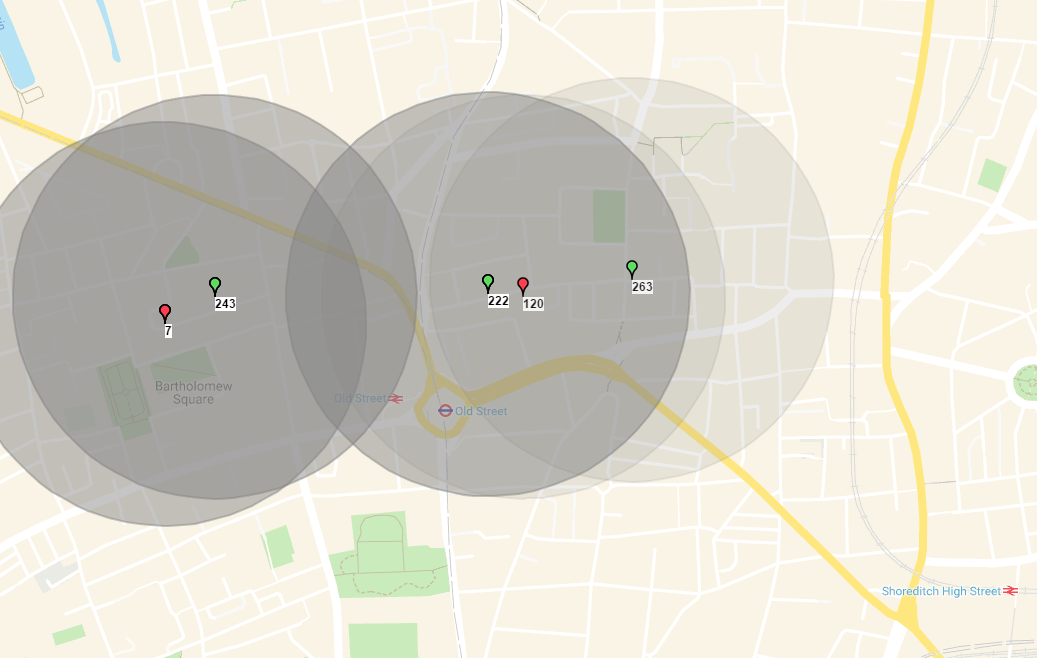

In [12]:
show_img_from_url("http://i.imgur.com/HharfEq.png")

In some areas however, the solution to remove one fascia is less obvious. In the below example, a large number of stores overlap with each other. In order to fully remove one fascia, it is not immediately obvious which stores will need to be sold (or whether there are multiple solutions).

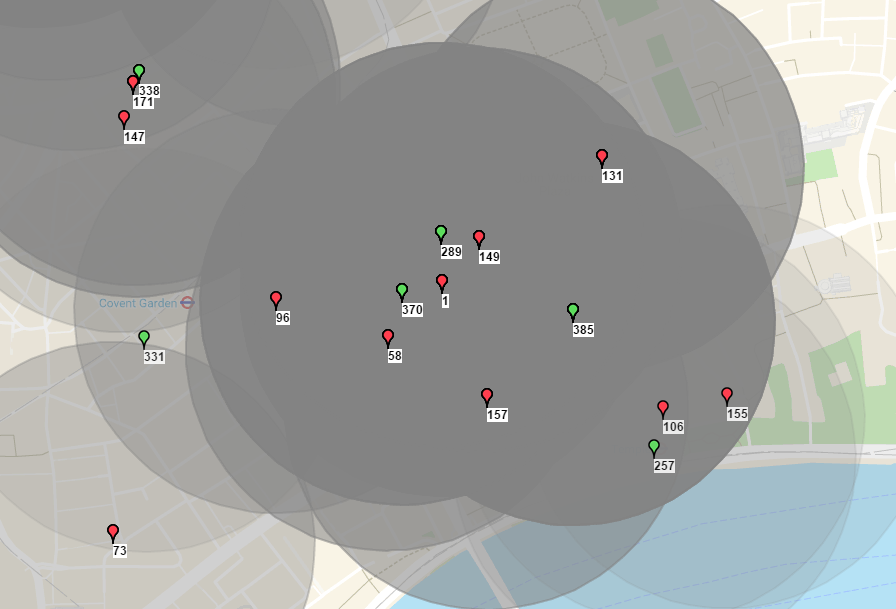

In [13]:
show_img_from_url("http://i.imgur.com/1fMyuOm.png") 

# Linear optimisation

I therefore use linear optimisation to solve the problem. I need to define my problem in a linear optimisation fashion - i.e. maximise X subject to Y constraints.

### Constraints

I first set up a constraint dictionary - this maps each store to each store that falls within its catchment. For example, if store 100 overlaps with stores 101 and 102, then its constraint dictionary will map 100: 100, 101, 102 (as the store itself is necessarily within its own catchment). 

### Variables for model

I then define the variables for the model - i.e. which stores can potentially be sold. These are simple all the stores within any stores' catchment. 

In [14]:
# Constraints
cons_dict = {}
for st in set(df_prob['To_number']):
    # Add in the centre store
    constraint = set(list(df_prob[df_prob['Centre_number'] == st].To_number)) 
    if len(constraint):
        cons_dict[str(st)] = constraint
        
# List of variables for model
store_vars = set([item for sublist in cons_dict.values() for item in sublist])

# Generate dictionary that maps from store number to store brand
store_type_dict = df_prob[['To_number', 'To_store']].set_index('To_number').to_dict()['To_store']

print(len(cons_dict))
print(len(store_vars))

120
227


## Defining the linear problem

I first define optimisation problem - maximise the number of stores that are kept out of the list of all stores (defined above).

I then need to translate the contraints. As a simplistic approach, I could just define the constraint such that for each area, at least one store must be sold. This would solve the SLC in each area if the sold store was sold to an entirely new fascia - e.g. brand X. 

Instead however, I define a more stringent scenario (and much more interesting from an LP-perspective) in which I assume that I cannot simply sell a single store, but rather have to sell all the stores of that fascia type (A or B) to satisfy the CMA. So, if a problematic area has stores A/A/B/B/C, then I then I need to either sell A/A or B/B (not just a single A or B). 

Translating the above into a linear optimisation problem, each store gets a variable which can be turned on or off depending on whether the store is sold, e.g.:
```
A_101 = 0 (store 101 (an A store) is sold)

B_201 = 1 (store 201 (a B store) is kept)
```
The constraints for the fascia reduction can be thought of as:
```
A_stores_present + B_stores_present <= 1
```

where A_store_present = max(A_101, A_102, A_103) - i.e. a variable equal to 1 if any A stores are kept, and zero if all are sold (in this example there are only three A stores).

In linear programming, I can translate this max function as:

```
A_store_present >= A_101

A_store_present >= A_102

A_store_present >= A_103

A_store_present <= A_101 + A_102 + A_103 
```
If any stores are kept, A_store_present has a value of 1, and only takes a value of 0 when all stores are sold. 

In [15]:
def solve_lp_problem(store_vars, cons_dict, store_type_dict):
    
    # Create LP problem
    prob = LpProblem("Minimise store divestments/maximise stores kept", LpMaximize)

    # Variables
    x = {}
    for store_id in store_vars:
        x[store_id] = LpVariable("Store_{0}".format(store_id), 0, 1, LpBinary)

    # Constraints
    constraint_max_dict = {}
    
    # Loop through constraints
    for cons_name, store_ids in cons_dict.items():

        # Extract stores
        A_stores = [st for st in store_ids if store_type_dict[st] == 'A']
        B_stores = [st for st in store_ids if store_type_dict[st] == 'B']

        # Create max function for A
        constraint_max_dict[cons_name + '_A'] = LpVariable(cons_name + '_A', 0, 1, LpBinary)
        
        for st in A_stores:
            prob += constraint_max_dict[cons_name + '_A'] >= x[st]
            
        prob += constraint_max_dict[cons_name + '_A'] <= lpSum(x[st] for st in A_stores)

        # Create max function for B
        constraint_max_dict[cons_name + '_B'] = LpVariable(cons_name + '_B', 0, 1, LpBinary)

        for st in B_stores:
            prob += constraint_max_dict[cons_name + '_B'] >= x[st]

        prob += constraint_max_dict[cons_name + '_B'] <= lpSum(x[st] for st in B_stores)

        # Create the fascia reduction constraint
        prob += constraint_max_dict[cons_name + '_A'] + constraint_max_dict[cons_name + '_B'] <= 1

    # Objective
    prob += lpSum(x[s] for s in store_vars)

    # Formula (can print this for debugging)
    #print(prob)

    # Solve - can alternatively export the problem as an LP file for use in another solver
    #prob.writeLP('cplex.lp')
    prob.solve()

    # Report
    print("Status: ", LpStatus[prob.status])
    print("Maximised obj: ", value(prob.objective))

    return x

In [16]:
## Solve the problem

xvar = solve_lp_problem(store_vars, cons_dict, store_type_dict)

kept_stores = [st for st in xvar if xvar[st].varValue]
sold_stores = [st for st in xvar if not xvar[st].varValue]

print("Kept {0} stores".format(len(kept_stores)))
print("Sold {0} stores ".format(len(sold_stores)))

Status:  Optimal
Maximised obj:  148.0
Kept 148 stores
Sold 79 stores 


## Check the solution

In the above example, 148 stores were kept, 79 were sold, from a total of 227. I now want to make sure that my optimiser is working correctly - so I generate a new database with all of those stores removed and recalculate the fascia reductions.

In [17]:
## Remove the sold stores from the original database 

df_dropped = df_dist.copy()
df_dropped = df_dropped[df_dropped['Centre_number'].isin(sold_stores) == False]
df_dropped = df_dropped[df_dropped['To_number'].isin(sold_stores) == False]
print(df_dropped.shape)
df_dropped.head()

(6759, 9)


,Centre_lat,Centre_lon,Centre_number,Centre_store,To_lat,To_lon,To_number,To_store,metres
0,51.505841,-0.089535,54,A,51.505841,-0.089535,54,A,0.000000
1,51.525025,-0.058356,455,G,51.525025,-0.058356,455,G,0.000000
2,51.485045,-0.027175,757,K,51.485045,-0.027175,757,K,0.000000
3,51.504706,-0.068117,118,A,51.502750,-0.066630,9,A,240.894321
4,51.511506,-0.084893,891,D,51.511506,-0.084893,891,D,0.000000


In [18]:
## Recalculate fascia reductions and check that no 4 to 3s etc still exist

df_fascia_opt = return_df_with_fascia_counts(df_dropped)
print(df_fascia_opt['Fascia'].unique())

['7 to 6' '6 to 5' '5 to 4' '8 to 7' '10 to 9' '9 to 8']


## Success

The solution appears correct - all 4 to 3 and below areas have now been removed. 

In the simple example given earlier, I stated that store 120 should be sold, to solve the SLC.

Looking at the list of sold stores, store 120 was indeed sold, whilst stores 222 and 263 were kept. This is at least some proof that the optimiser is working as expected.

In [19]:
print(120 in sold_stores)

print(222 in kept_stores)
print(263 in kept_stores)

True
True
True


## Extension - clusters

In the simple example of the group of stores 120/222/263, from the map it was clear that no other stores overlapped with this area. As a result, the solution to this group of stores has no effect on any other stores.

In graph theory, this group of stores is called a cluster. Since separate clusters by definition do not affect other clusters, I can solve the linear optimisation problem by individual cluster rather than the entire dataset as a whole. 

In [20]:
## Set up a colour dictionary for graphing

colour_nodes = df.copy()
colour_nodes.set_index('number', inplace=True)

colour_dict = {"A": "red",
               "B": "green"
              }

colour_nodes['colour'] = colour_nodes['store'].map(colour_dict)
colour_nodes_dict = colour_nodes[['colour']].to_dict()['colour']

In [21]:
## Define the edges of the graph
data_edges = list(zip(df_prob['Centre_number'], df_prob['To_number']))

## Create graph object using network x
G = nx.Graph()
G.add_edges_from(data_edges)

## Generate list of all clusters
connections_nx = nx.connected_components(G)

list_clusters = [x for x in connections_nx]

## Look at  the specific cluster shown in the simple example
specific_cluster = list(list_clusters[-9])
print(specific_cluster)

[120, 222, 263]


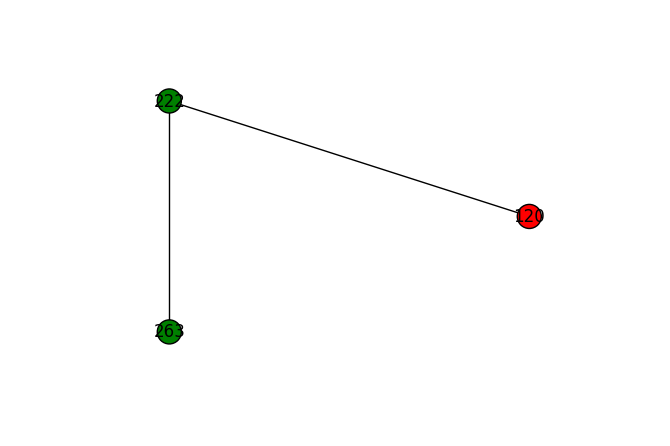

In [22]:
## Draw the specific cluster

df_cluster = df_prob[(df_prob["Centre_number"].isin(specific_cluster))]

cluster_edges = list(zip(df_cluster['Centre_number'], df_cluster['To_number']))

G_cluster = nx.Graph()
G_cluster.add_edges_from(cluster_edges)

node_colours = [colour_nodes_dict[node] for node in G_cluster.nodes()]
nx.draw_circular(G_cluster, with_labels=True, node_color=node_colours)

## Solve by cluster

Once I've split up my database into clusters, I can simply loop through these clusters and solve each one individually, appending the results as I go.


In [23]:
connections_nx = nx.connected_components(G)
all_sold_stores = []

## Loop through the clusters
for c, cluster in enumerate(connections_nx):
    print("Running cluster {0}".format(c+1))
    cons_dict_cluster = {}
    for st in cluster:
        constraint = set(list(df_prob[df_prob['Centre_number'] == st].To_number))
        if len(constraint):
            cons_dict_cluster[str(st)] = constraint
            
    store_vars_cluster = set([item for sublist in cons_dict_cluster.values() for item in sublist])
    # Solve the cluster
    xvar = solve_lp_problem(store_vars_cluster, cons_dict_cluster, store_type_dict)
    # Feedback
    sold_stores_cluster = [st for st in xvar if not xvar[st].varValue]
    all_sold_stores.extend(sold_stores_cluster)

Running cluster 1
Status:  Optimal
Maximised obj:  8.0
Running cluster 2
Status:  Optimal
Maximised obj:  6.0
Running cluster 3
Status:  Optimal
Maximised obj:  3.0
Running cluster 4
Status:  Optimal
Maximised obj:  1.0
Running cluster 5
Status:  Optimal
Maximised obj:  3.0
Running cluster 6
Status:  Optimal
Maximised obj:  6.0
Running cluster 7
Status:  Optimal
Maximised obj:  6.0
Running cluster 8
Status:  Optimal
Maximised obj:  8.0
Running cluster 9
Status:  Optimal
Maximised obj:  7.0
Running cluster 10
Status:  Optimal
Maximised obj:  7.0
Running cluster 11
Status:  Optimal
Maximised obj:  12.0
Running cluster 12
Status:  Optimal
Maximised obj:  5.0
Running cluster 13
Status:  Optimal
Maximised obj:  2.0
Running cluster 14
Status:  Optimal
Maximised obj:  5.0
Running cluster 15
Status:  Optimal
Maximised obj:  5.0
Running cluster 16
Status:  Optimal
Maximised obj:  6.0
Running cluster 17
Status:  Optimal
Maximised obj:  4.0
Running cluster 18
Status:  Optimal
Maximised obj:  3.0


In [24]:
print("Sold {0} stores ".format(len(all_sold_stores)))

for x in sold_stores:
    if x not in all_sold_stores:
        print(x, x in all_sold_stores)


Sold 79 stores 
7 False
79 False
156 False
158 False
178 False
189 False


## Results + further extensions

In both situations, the solution involves selling exactly 79 stores. However, the exact composition of these stores differs between the two solutions. This makes sense - for some areas, there are multiple solutions that still result in the same maximised objective function. 

If speed of solution were a problem, I could run the clustered solve in parallel. However for my example above, the speed difference between the two is so minor that it's unnecessary. I could also export the LP file and use a different solver (e.g. CPLEX). Again however, PuLP does the job just fine in this case. 